
Point Count Comparison for scene0020_00:
  Previous: 151489
  Current: 280164
  Difference: 128675

Label Distribution Comparison:

segment20 Distribution:
  Previous -1 ratio: 0.4596
  Current -1 ratio: 0.5285
  Difference: 0.0690


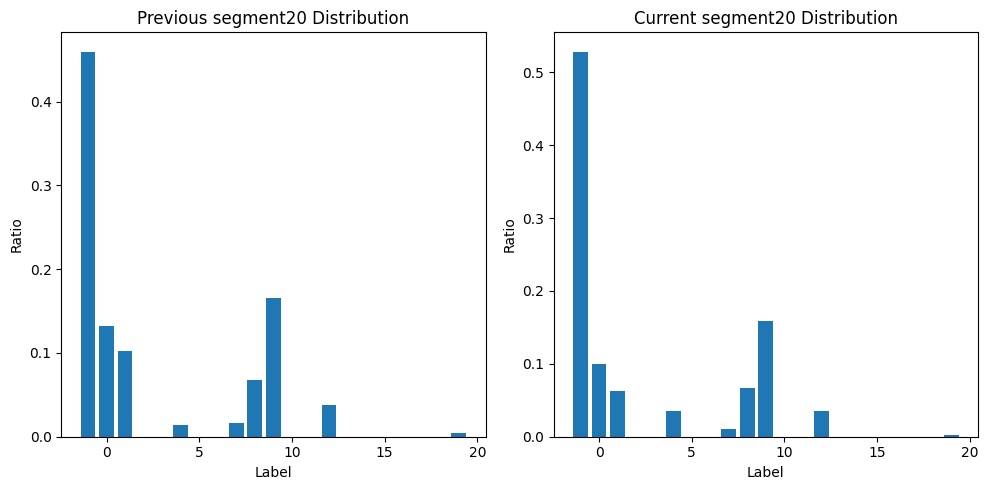


segment200 Distribution:
  Previous -1 ratio: 0.0994
  Current -1 ratio: 0.0795
  Difference: -0.0199


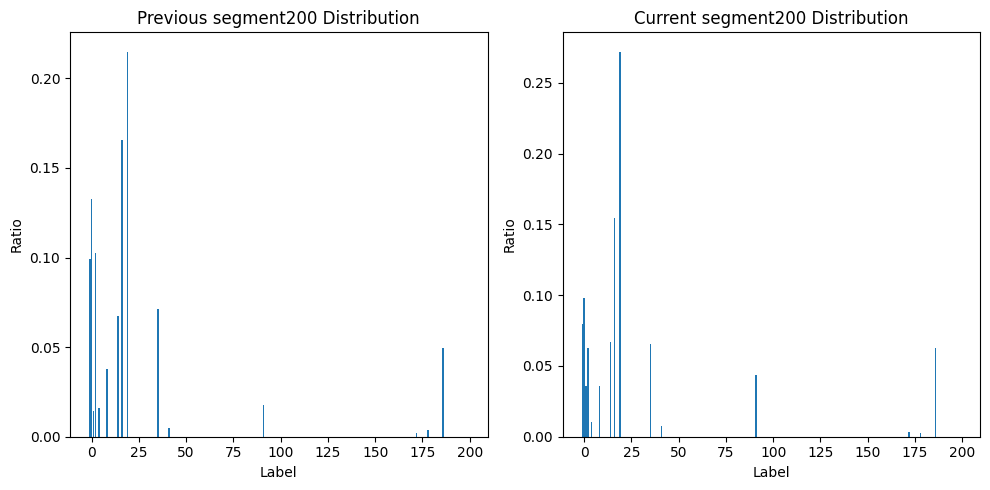


instance Distribution:
  Previous -1 ratio: 0.0994
  Current -1 ratio: 0.0795
  Difference: -0.0199


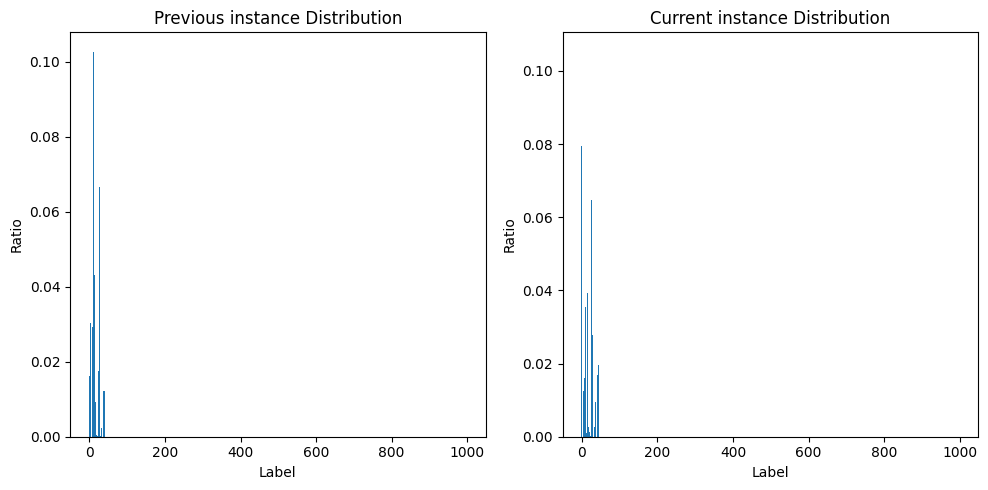


Color and Normal Statistics Comparison:

color:
  Previous Mean: [90.02579065 78.70999875 71.94994356]
  Current Mean: [92.41915806 81.08741309 74.53404435]
  Mean Difference: [2.39336741 2.37741434 2.58410079]
  Previous Std: [73.93450887 74.23980148 73.91977128]
  Current Std: [71.11585341 71.19341841 70.64451303]
  Std Difference: [-2.81865546 -3.04638307 -3.27525825]

normal:
  Previous Mean: [ 0.00366936 -0.02069863  0.10702455]
  Current Mean: [-0.00957496 -0.01257977  0.04153134]
  Mean Difference: [-0.01324432  0.00811885 -0.06549321]
  Previous Std: [0.556327   0.59828484 0.56622857]
  Current Std: [0.5689398  0.623949   0.53373265]
  Std Difference: [ 0.01261282  0.02566415 -0.03249592]


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def load_pointcept_data(data_dir):
    """Pointcept 데이터를 로드 (가정된 함수)"""
    data = {}
    for key in ['coord', 'color', 'normal', 'segment20', 'segment200', 'instance']:
        file_path = f"{data_dir}/{key}.npy"
        data[key] = np.load(file_path)
    return data

def compute_label_distribution(labels, ignore_index=-1, max_label=20):
    """라벨 분포 계산"""
    distribution = {}
    valid_labels = labels[labels != ignore_index]
    for label in range(-1, max_label):
        count = np.sum(labels == label)
        distribution[label] = count / len(labels)
    return distribution

def compare_datasets(previous_dir, current_dir, scene_name="scene0010_00"):
    """
    이전 데이터셋과 현재 데이터셋 비교.
    
    Args:
        previous_dir (str): 이전 데이터셋 경로.
        current_dir (str): 현재 데이터셋 경로.
        scene_name (str): 장면 이름.
    """
    # 데이터 로드
    previous_data = load_pointcept_data(previous_dir)
    current_data = load_pointcept_data(current_dir)

    # 포인트 수 비교
    prev_points = len(previous_data['coord'])
    curr_points = len(current_data['coord'])
    print(f"\nPoint Count Comparison for {scene_name}:")
    print(f"  Previous: {prev_points}")
    print(f"  Current: {curr_points}")
    print(f"  Difference: {curr_points - prev_points}")

    # 라벨 분포 비교
    print("\nLabel Distribution Comparison:")
    for label_key in ['segment20', 'segment200', 'instance']:
        max_label = 20 if label_key == 'segment20' else 200 if label_key == 'segment200' else 1000
        prev_dist = compute_label_distribution(previous_data[label_key], max_label=max_label)
        curr_dist = compute_label_distribution(current_data[label_key], max_label=max_label)

        print(f"\n{label_key} Distribution:")
        print(f"  Previous -1 ratio: {prev_dist[-1]:.4f}")
        print(f"  Current -1 ratio: {curr_dist[-1]:.4f}")
        print(f"  Difference: {curr_dist[-1] - prev_dist[-1]:.4f}")

        # 히스토그램 시각화
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.bar(list(prev_dist.keys()), list(prev_dist.values()))
        plt.title(f"Previous {label_key} Distribution")
        plt.xlabel("Label")
        plt.ylabel("Ratio")
        plt.subplot(1, 2, 2)
        plt.bar(list(curr_dist.keys()), list(curr_dist.values()))
        plt.title(f"Current {label_key} Distribution")
        plt.xlabel("Label")
        plt.ylabel("Ratio")
        plt.tight_layout()
        plt.show()

    # 색상 및 법선 통계 비교
    print("\nColor and Normal Statistics Comparison:")
    for key in ['color', 'normal']:
        prev_mean = np.mean(previous_data[key], axis=0)
        prev_std = np.std(previous_data[key], axis=0)
        curr_mean = np.mean(current_data[key], axis=0)
        curr_std = np.std(current_data[key], axis=0)
        print(f"\n{key}:")
        print(f"  Previous Mean: {prev_mean}")
        print(f"  Current Mean: {curr_mean}")
        print(f"  Mean Difference: {curr_mean - prev_mean}")
        print(f"  Previous Std: {prev_std}")
        print(f"  Current Std: {curr_std}")
        print(f"  Std Difference: {curr_std - prev_std}")

# 사용 예시
previous_dir = "/home/knuvi/Desktop/song/Pointcept/data/scannet/train/scene0020_00"
current_dir = "/home/knuvi/Desktop/song/Pointcept/data/pdistance00005_scale05_ig06/train/scene0020_00"
compare_datasets(previous_dir, current_dir, "scene0020_00")

In [2]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def compute_local_consistency(data, k=10):
    """
    로컬 일관성 계산.
    
    Args:
        data (dict): 데이터 딕셔너리 (coord, color, normal, segment20 등 포함).
        k (int): KNN 이웃 수.
    
    Returns:
        dict: 로컬 일관성 메트릭.
    """
    coords = data['coord']
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    metrics = {
        'color_variance': [],
        'normal_cosine_similarity': [],
        'label_consistency': []
    }

    for i in range(len(coords)):
        # KNN 이웃
        nearest_indices = indices[i][1:]  # 자기 자신 제외
        nearest_colors = data['color'][nearest_indices]
        nearest_normals = data['normal'][nearest_indices]
        nearest_labels = data['segment20'][nearest_indices]

        # 색상 분산
        color_var = np.var(nearest_colors, axis=0).mean()
        metrics['color_variance'].append(color_var)

        # 법선 코사인 유사도
        normal = data['normal'][i]
        cos_sims = []
        for j in range(len(nearest_normals)):
            norm = np.linalg.norm(normal) * np.linalg.norm(nearest_normals[j])
            if norm > 0:
                cos_sim = np.dot(normal, nearest_normals[j]) / norm
                cos_sims.append(cos_sim)
        metrics['normal_cosine_similarity'].append(np.mean(cos_sims) if cos_sims else 0)

        # 라벨 일치도
        label = data['segment20'][i]
        if label >= 0:  # 유효 라벨만 고려
            consistency = np.mean(nearest_labels == label)
            metrics['label_consistency'].append(consistency)

    # 평균 메트릭 계산
    result = {
        'color_variance': np.mean(metrics['color_variance']),
        'normal_cosine_similarity': np.mean(metrics['normal_cosine_similarity']),
        'label_consistency': np.mean(metrics['label_consistency']) if metrics['label_consistency'] else 0
    }
    return result

def validate_pattern_consistency(pointcept_dir, merged_dir, scene_name="scene0010_00", k=10):
    """
    Pointcept와 병합 데이터 간 패턴 일치도 검증.
    
    Args:
        pointcept_dir (str): Pointcept 데이터 경로.
        merged_dir (str): 병합 데이터 경로.
        scene_name (str): 장면 이름.
        k (int): KNN 이웃 수.
    """
    # 데이터 로드
    pointcept_data = load_pointcept_data(pointcept_dir)
    merged_data = load_pointcept_data(merged_dir)

    # Pointcept 데이터에서 Pointcept 포인트만 추출 (병합 데이터에서 Pointcept 부분)
    merged_pointcept_coords = merged_data['coord'][:len(pointcept_data['coord'])]
    merged_pointcept_data = {
        'coord': merged_pointcept_coords,
        'color': merged_data['color'][:len(pointcept_data['coord'])],
        'normal': merged_data['normal'][:len(pointcept_data['coord'])],
        'segment20': merged_data['segment20'][:len(pointcept_data['coord'])]
    }

    # 로컬 일관성 계산
    pointcept_metrics = compute_local_consistency(pointcept_data, k=k)
    merged_metrics = compute_local_consistency(merged_pointcept_data, k=k)

    # 결과 비교
    print(f"\nPattern Consistency Validation for {scene_name}:")
    print("Color Variance (lower is better):")
    print(f"  Pointcept: {pointcept_metrics['color_variance']:.4f}")
    print(f"  Merged (Pointcept part): {merged_metrics['color_variance']:.4f}")
    print(f"  Difference: {merged_metrics['color_variance'] - pointcept_metrics['color_variance']:.4f}")

    print("\nNormal Cosine Similarity (higher is better):")
    print(f"  Pointcept: {pointcept_metrics['normal_cosine_similarity']:.4f}")
    print(f"  Merged (Pointcept part): {merged_metrics['normal_cosine_similarity']:.4f}")
    print(f"  Difference: {merged_metrics['normal_cosine_similarity'] - pointcept_metrics['normal_cosine_similarity']:.4f}")

    print("\nLabel Consistency (higher is better):")
    print(f"  Pointcept: {pointcept_metrics['label_consistency']:.4f}")
    print(f"  Merged (Pointcept part): {merged_metrics['label_consistency']:.4f}")
    print(f"  Difference: {merged_metrics['label_consistency'] - pointcept_metrics['label_consistency']:.4f}")

# 사용 예시
pointcept_dir = "/home/knuvi/Desktop/song/Pointcept/data/scannet/train/scene0010_00"
merged_dir = "/home/knuvi/Desktop/song/Pointcept/data/pdistance00005_scale05_modi-attr/train/scene0010_00"
validate_pattern_consistency(pointcept_dir, merged_dir, "scene0010_00", k=10)


Pattern Consistency Validation for scene0010_00:
Color Variance (lower is better):
  Pointcept: 370.8503
  Merged (Pointcept part): 370.8503
  Difference: 0.0000

Normal Cosine Similarity (higher is better):
  Pointcept: 0.8132
  Merged (Pointcept part): 0.8132
  Difference: 0.0000

Label Consistency (higher is better):
  Pointcept: 0.9554
  Merged (Pointcept part): 0.9554
  Difference: 0.0000
